In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [281]:
# read in data
df_eng = pd.read_csv('tutor_data.csv').drop(columns='Unnamed: 0')

# basic cuts on targets
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] < 60].index]
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] > 0.25].index]
df_eng = df_eng.loc[df_eng[df_eng['rate'] <= 200].index]
df_eng = df_eng.loc[df_eng[df_eng['rate'] >= 10].index]


In [282]:
df_eng['rate'].describe()

count    2106.000000
mean       52.924976
std        25.898378
min        10.000000
25%        36.000000
50%        49.000000
75%        60.000000
max       200.000000
Name: rate, dtype: float64

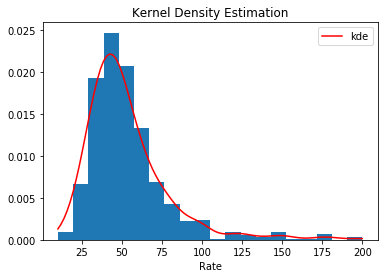

In [284]:
plt.hist(df_eng.rate, bins=20, range=(10,200), density=True)
plt.xlabel('Rate')
gkde = stats.gaussian_kde(df_eng.rate, bw_method = 0.3, weights=None)
ind = np.linspace(10,200,101)
kdepdf = gkde.evaluate(ind)
#plt.figure()
plt.plot(ind, kdepdf, label='kde', color="r")
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [74]:
df_eng['hours_per_week_estimate'].describe()

count    2123.000000
mean        3.257954
std         4.216706
min         0.250182
25%         0.803704
50%         1.750000
75%         3.995593
max        49.000000
Name: hours_per_week_estimate, dtype: float64

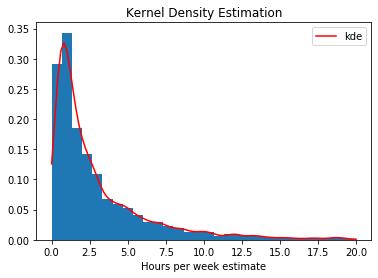

In [286]:
plt.hist(df_eng.hours_per_week_estimate, bins=30, range=(0,20), density=True)
plt.xlabel('Hours per week estimate')
gkde = stats.gaussian_kde(df_eng.hours_per_week_estimate, bw_method = 0.1, weights=None)
ind = np.linspace(0,20,101)
kdepdf = gkde.evaluate(ind)
#plt.figure()
plt.plot(ind, kdepdf, label='kde', color="r")
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [285]:
def string_to_list(i):
    x = i.replace('[', '').replace(']', '').replace('\'', '').split(',')
    list_i = list()
    for j in x:
        list_i.append(j.lstrip().rstrip())
    return list_i

subjects_all_list = []
for i in df_eng['subjects_all']:
    subjects_all_list.append(string_to_list(i))
df_eng['subjects_list'] = np.array(subjects_all_list)

subjects_emph_list = []
for i in df_eng['subjects_emph']:
    subjects_emph_list.append(string_to_list(i))
df_eng['subjects_emph_list'] = np.array(subjects_emph_list)

#edu_list = []
#for i in df_eng['edu']:
#    edu_list.append(string_to_list(i))
#df_eng['edu_list'] = np.array(edu_list)

In [102]:
# engineer subjects categories

feature = 'subjects_list'
size_subjects = len(df_eng[feature].explode().value_counts().index)
popular_subjects = list(df_eng[feature].explode().value_counts().index[:size_subjects//3])
mid_subjects = list(df_eng[feature].explode().value_counts().index[size_subjects//3:(size_subjects//3 + size_subjects//3)])
unpopular_subjects = list(df_eng[feature].explode().value_counts().index[(size_subjects//3 + size_subjects//3):])

unwanted = ''
if unwanted in popular_subjects:
    popular_subjects.remove(unwanted)
elif unwanted in mid_subjects:
    mid_subjects.remove(unwanted)
elif unwanted in unpopular_subjects:
    unpopular_subjects.remove(unwanted)

popular_list = []
mid_list = []
unpopular_list = []
for f in df_eng[feature]:
    num_popular = 0
    num_mid = 0
    num_unpopular = 0
    for j in f:
        if j in popular_subjects:
            num_popular += 1
        elif j in mid_subjects:
            num_mid += 1
        elif j in unpopular_subjects:
            num_unpopular += 1
    popular_list.append(num_popular)
    mid_list.append(num_mid)
    unpopular_list.append(num_unpopular)
    
df_eng['num_popular_subjects'] = np.array(popular_list)
df_eng['num_mid_subjects'] = np.array(mid_list)
df_eng['num_unpopular_subjects'] = np.array(unpopular_list)

In [287]:
# engineer edu degree categories

undergrad = ['BA', 'B.A.', 'BS', 'B.S.', '']
postgrad = ['MS', 'M.S', 'MA', 'M.A', 'masters', 'Masters', 'CA', 'C.A', 
            'MBA', 'M.B.A', 'MD', 'M.D', 'PhD', 'Ph.D', 'Ph.D.', 'Graduate']
certified = ['education', 'Ced', 'certified']

undergrad_degree = []
postgrad_degree = []
certified_degree = []
for e in df_eng['edu']:
    undergrad_count = 0
    postgrad_count = 0
    certified_count = 0
    if any(x in e for x in undergrad):
        undergrad_count += 1
    if any(x in e for x in postgrad):
        postgrad_count += 1
    if any(x in e for x in certified):
        certified_count +=1
    undergrad_degree.append(undergrad_count)
    postgrad_degree.append(postgrad_count)
    certified_degree.append(certified_count)
df_eng['undergrad_degree'] = np.array(undergrad_degree)
df_eng['postgrad_degree'] = np.array(postgrad_degree)
df_eng['certified_degree'] = np.array(certified_degree)

In [104]:
# get university rankings
df_wur = pd.read_csv('world-university-rankings_cwurData.csv')
df_wur_select = df_wur[['institution', 'world_rank']]

list_of_top_schools = (list(df_wur_select['institution'][:30]) + 
['Berkeley', 'Caltech', 'Harvard', 'Yale', 'Princeton', 'MIT', 'Stanford'])

top_school = []
for e in df_eng['edu']:
    top = 0
    if any(x in e for x in list_of_top_schools):
        top += 1
    top_school.append(top)
df_eng['top_school'] = np.array(top_school)

Feature ranking:
feature number_subjects (0.17)
feature descriptions_length (0.12)
feature rate (0.11)
feature hours_per_week_schedule (0.11)
feature bio_length (0.11)
feature hours_thurs (0.07)
feature hours_sat (0.07)
feature hours_sun (0.06)
feature hours_mon (0.05)
feature hours_fri (0.03)
feature hours_wed (0.03)
feature hours_tues (0.03)
feature number_degrees (0.02)
feature postgrad_degree (0.02)
feature certified_degree (0.00)
feature undergrad_degree (0.00)


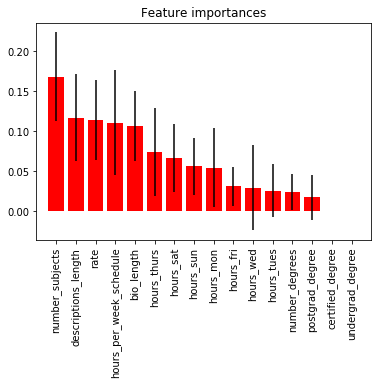

In [288]:
rf = RandomForestRegressor(n_estimators=50, criterion='mse', min_samples_leaf=10, random_state=0)
targets = ['rate', 'hours_per_week_estimate']
cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 
                'edu', 'bg_check_date', 'earliest_review_date', 'subjects_emph', 'subjects_all']
X = df_eng.drop(columns=(['hours_per_week_estimate'] + cols_to_drop))
y = df_eng['hours_per_week_estimate']
features = list(X.columns)
rf.fit(X, y)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

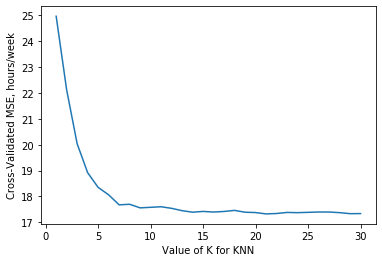

In [225]:
k_range = range(1, 31)
k_scores = []
X_top = X
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k)
    loss = abs(cross_val_score(knn, X_top, y, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE, hours/week')
plt.show()

In [314]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

ValueError: Expected 2D array, got 1D array instead:
array=[16.45945946  6.55186211  0.64159812 ...  0.2972973   1.27648931
  1.16918647].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
X = df_eng.drop(columns=(['hours_per_week_estimate'] + cols_to_drop))
y = df_eng['hours_per_week_estimate']
for i in range(len(test)):
    
    X_sub = X[test[:(i+1)]]

    knn = KNeighborsRegressor(weights='distance', n_neighbors = 14)
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, random_state=0)

    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    print(i, ' features', ' ', r2_score(y_test, y_predict))